In [17]:
import numpy as np
import pandas as pd
import math, os
from pandas import Series, DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
from matplotlib import pyplot as plt

## Modbus TCP SCADA #1

Source: https://github.com/tjcruz-dei/ICS_PCAPS

This dataset was generated on a small-scale process automation scenario using MODBUS/TCP equipment, for research on the application of ML techniques to cybersecurity in Industrial Control Systems. The testbed emulates a CPS process controlled by a SCADA system using the MODBUS/TCP protocol. It consists of a liquid pump simulated by an electric motor controlled by a variable frequency drive (allowing for multiple rotor speeds), which in its turn controlled by a Programmable Logic Controller (PLC). The motor speed is determined by a set of predefined liquid temperature thresholds, whose measurement is provided by a MODBUS Remote Terminal Unit (RTU) device providing a temperature gauge, which is simulated by a potentiometer connected to an Arduino. The PLC communicates horizontally with the RTU, providing insightful knowledge of how this type of communications may have an effect on the overall system. The PLC also communicates with the Human-Machine Interface (HMI) controlling the system.


HMI <----> PLC ---> VFD ---> 3-phase motor

            ^
            
            |
      Arduino-based RTU


In [2]:
df = pd.read_csv("/Users/z/Python/ICS_Demo/malicious.csv")

In [3]:
# Define attacks
def attack_success(row):
    if "Write" in row['Info']:
        return 1
    else:
        return 0

In [4]:
# Apply this definition to a new column
df['Label'] = df.apply(attack_success, axis=1)

In [5]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Label
0,1,0.000000,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=1 Ack=1 Win=65175 Len=0,0
1,2,0.095448,172.27.224.70,172.27.224.250,Modbus/TCP,66,"Query: Trans: 0; Unit: 1, Func: 3: ...",0
2,3,0.102847,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0
3,4,0.273109,HewlettP_8e:40:b3,Spanning-tree-(for-bridges)_00,STP,64,RST. Root = 32768/0/00:18:6e:d7:8a:c0 Cost = ...,0
4,5,0.311994,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=13 Ack=32 Win=65144 Len=0,0
...,...,...,...,...,...,...,...,...
841669,841670,43198.902826,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0
841670,841671,43199.108516,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=1595377 Ack=4121389 Wi...,0
841671,841672,43199.202907,172.27.224.70,172.27.224.250,Modbus/TCP,66,"Query: Trans: 0; Unit: 1, Func: 3: ...",0
841672,841673,43199.212185,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0


In [6]:
df['Label'].value_counts()

0    826779
1     14895
Name: Label, dtype: int64

In [7]:
df['Source'].unique()

array(['172.27.224.70', '172.27.224.250', 'HewlettP_8e:40:b3',
       '172.27.224.251', 'AsustekC_64:40:79', 'Telemech_09:51:3b',
       'Vmware_9d:9e:9e', '::', '0.0.0.0', 'fe80::20c:29ff:fee6:1421',
       'fe80::7104:572e:8c13:2f20', 'fe80::20c:29ff:fe4d:512a',
       'fe80::2591:3422:2a18:9404', 'fe80::20c:29ff:fe4d:5116',
       'fe80::20c:29ff:fe19:606b'], dtype=object)

<AxesSubplot:xlabel='Length', ylabel='count'>

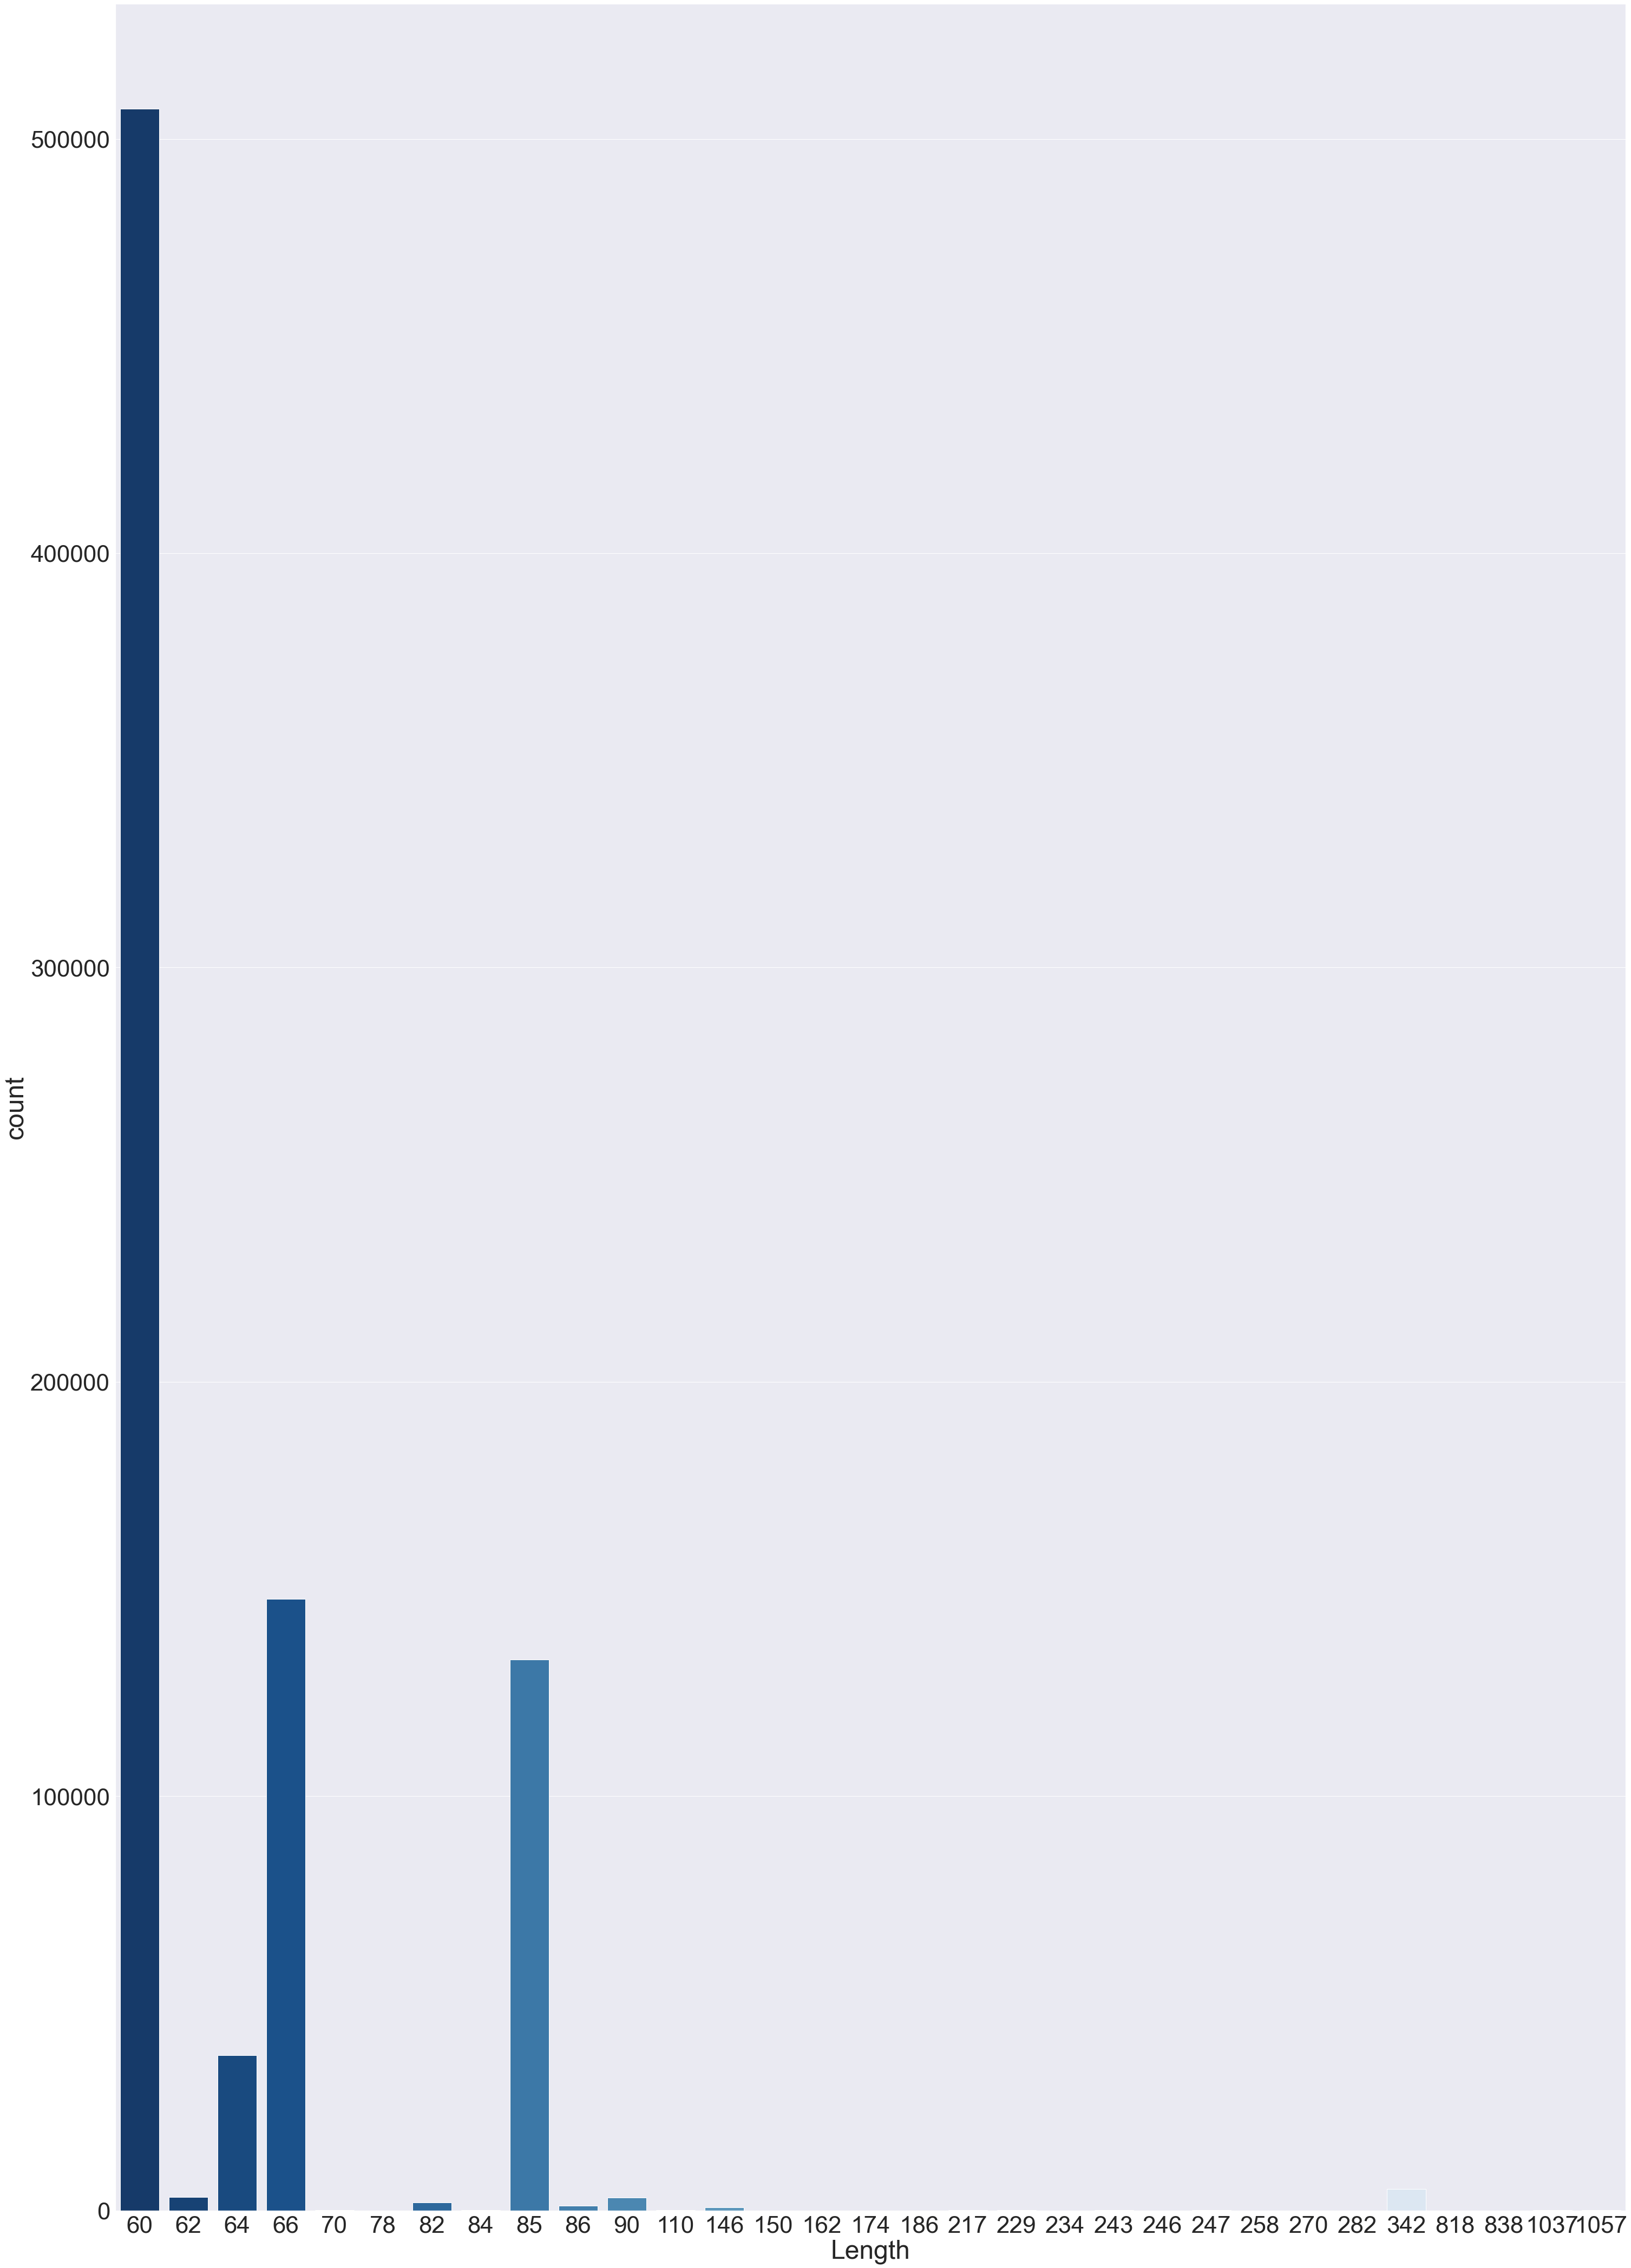

In [8]:
plt.rcParams["figure.figsize"] = [0.5, 1]
sns.set_style("darkgrid")

%matplotlib inline

sns.set(rc={'figure.figsize':(50,75)})
sns.set(font_scale=4) 
sns.countplot(x="Length", data=df, palette="Blues_r")

In [9]:
src_dummies = pd.get_dummies(df['Source'])
dst_dummies = pd.get_dummies(df['Destination'])
prot_dummies = pd.get_dummies(df['Protocol'])

# Concatenate the dummy variable table with our 'X' variable table
X = pd.concat([src_dummies, dst_dummies, prot_dummies, df], axis=1)

In [10]:
X

,0.0.0.0,172.27.224.250,172.27.224.251,172.27.224.70,::,AsustekC_64:40:79,HewlettP_8e:40:b3,Telemech_09:51:3b,Vmware_9d:9e:9e,fe80::20c:29ff:fe19:606b,...,TCP,UDP,No.,Time,Source,Destination,Protocol,Length,Info,Label
0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0.000000,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=1 Ack=1 Win=65175 Len=0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0.095448,172.27.224.70,172.27.224.250,Modbus/TCP,66,"Query: Trans: 0; Unit: 1, Func: 3: ...",0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,3,0.102847,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,4,0.273109,HewlettP_8e:40:b3,Spanning-tree-(for-bridges)_00,STP,64,RST. Root = 32768/0/00:18:6e:d7:8a:c0 Cost = ...,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,5,0.311994,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=13 Ack=32 Win=65144 Len=0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841669,0,1,0,0,0,0,0,0,0,0,...,0,0,841670,43198.902826,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0
841670,0,0,0,1,0,0,0,0,0,0,...,1,0,841671,43199.108516,172.27.224.70,172.27.224.250,TCP,60,49179 > 502 [ACK] Seq=1595377 Ack=4121389 Wi...,0
841671,0,0,0,1,0,0,0,0,0,0,...,0,0,841672,43199.202907,172.27.224.70,172.27.224.250,Modbus/TCP,66,"Query: Trans: 0; Unit: 1, Func: 3: ...",0
841672,0,1,0,0,0,0,0,0,0,0,...,0,0,841673,43199.212185,172.27.224.250,172.27.224.70,Modbus/TCP,85,"Response: Trans: 0; Unit: 1, Func: 3: ...",0


In [11]:
X = df.drop(['No.','Time','Source','Destination','Protocol','Info','Label'], axis=1)

In [12]:
# Add the attack column to the Y variable - this is what we're classifying
Y = df['Label']

In [13]:
# Flatten array
y = np.ravel(Y)

In [14]:
X = X.dropna()

In [15]:
log_model = LogisticRegression()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [16]:
log_model.fit(X,Y)
log_model.score(X,Y) # Accuracy rating

0.9823031244876282